In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import plot_tree

In [3]:
df = pd.read_csv('aug_train.csv')

#df.shape = (19158, 14)
df.columns

Index(['enrollee_id', 'city', 'city_development_index', 'gender',
       'relevent_experience', 'enrolled_university', 'education_level',
       'major_discipline', 'experience', 'company_size', 'company_type',
       'last_new_job', 'training_hours', 'target'],
      dtype='object')

In [4]:
df.head(5)

enrollee_id      city  city_development_index gender  \
0         8949  city_103                   0.920   Male   
1        29725   city_40                   0.776   Male   
2        11561   city_21                   0.624    NaN   
3        33241  city_115                   0.789    NaN   
4          666  city_162                   0.767   Male   

       relevent_experience enrolled_university education_level  \
0  Has relevent experience       no_enrollment        Graduate   
1   No relevent experience       no_enrollment        Graduate   
2   No relevent experience    Full time course        Graduate   
3   No relevent experience                 NaN        Graduate   
4  Has relevent experience       no_enrollment         Masters   

  major_discipline experience company_size    company_type last_new_job  \
0             STEM        >20          NaN             NaN            1   
1             STEM         15        50-99         Pvt Ltd           >4   
2             STEM          5          NaN             NaN        never   
3  Business Degree         <1          NaN         Pvt Ltd        never   
4             STEM        >20        50-99  Funded Startup            4   

   training_hours  target  
0              36     1.0  
1              47     0.0  
2              83     0.0  
3              52     1.0  
4               8     0.0

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

In [6]:
df.isnull().sum()

enrollee_id                  0
city                         0
city_development_index       0
gender                    4508
relevent_experience          0
enrolled_university        386
education_level            460
major_discipline          2813
experience                  65
company_size              5938
company_type              6140
last_new_job               423
training_hours               0
target                       0
dtype: int64

In [7]:
# Анализ профиля кандидатов без указания размера компании: преобладают опытные специалисты с высшим образованием
no_company_size = df[df.company_size.isnull()]
no_company_size.head()
print(no_company_size.experience.value_counts().head())
print(f'\n{no_company_size.education_level.value_counts()}')

experience
>20    917
3      599
4      563
2      548
5      483
Name: count, dtype: int64

education_level
Graduate          3169
High School       1163
Masters            966
Primary School     244
Phd                 90
Name: count, dtype: int64


In [8]:
# Анализ кандидатов без образования: есть опыт работы
no_educ = df[df.education_level.isnull()]
no_educ.experience.value_counts().head()

experience
2      64
>20    56
3      48
5      43
4      34
Name: count, dtype: int64

In [9]:
# Анализ кандидатов без указания обучения в университете:имеют разнообразный опыт работы, наиболее частый статус - 'no_enrollment'
no_uni = df[df.enrolled_university.isnull()]
no_uni.experience.value_counts()
df.enrolled_university.value_counts().head()

enrolled_university
no_enrollment       13817
Full time course     3757
Part time course     1198
Name: count, dtype: int64

In [10]:
# Большинство кандидатов без major_discipline имеют школьное образование
df.major_discipline.value_counts()
no_discipline = df[df.major_discipline.isnull()]
no_discipline.education_level.value_counts()

education_level
High School       2017
Primary School     308
Graduate            22
Masters              6
Name: count, dtype: int64

In [11]:
# Тип компании company_type не указан у опытных специалистов
df.company_type.value_counts()
no_company_type = df[df.company_type.isnull()]
no_company_type.experience.value_counts()

experience
>20    920
3      590
4      582
2      547
5      503
6      383
7      321
<1     291
1      282
9      244
10     229
8      211
11     167
15     144
12     118
14     113
16     111
13      86
17      81
18      71
19      67
20      43
Name: count, dtype: int64

In [12]:
# Большинство кандидатов меняли работу недавно, '1' - наиболее распространенное значение
df.last_new_job.value_counts()

last_new_job
1        8040
>4       3290
2        2900
never    2452
4        1029
3        1024
Name: count, dtype: int64

In [13]:
def handle_missing_values(x):

    # Заполнение пропусков в категориальных признаках

    df = x.copy()

    # Заполнение пропусков наиболее частыми значениями
    df['education_level'] = df['education_level'].fillna('Graduate')           # Самый частый уровень образования, большинство кандидатов имеют опыт работы
    df['company_size'] = df['company_size'].fillna('Unknown')                  # Размер компании неизвестен, зачастую не указывают именно опытные специалисты
    df['gender'] = df['gender'].fillna('Not Specified')                        # Пол не указан, вероятно из-за нежелания указывать
    df['enrolled_university'] = df['enrolled_university'].fillna('no_enrollment') # Не обучается
    df['major_discipline'] = df['major_discipline'].fillna('STEM')             # В основном отсутствует у кандидатов с базовым образованием
    df['company_type'] = df['company_type'].fillna('Unknown')                  # Тип компании неизвестен
    df['experience'] = df['experience'].fillna('<1')                           # Минимальный опыт
    df['last_new_job'] = df['last_new_job'].fillna('1')                        # Наиболее частое значение '1'

    return df

# Применяем функцию к данным
df = handle_missing_values(df)

In [14]:
df.isnull().sum()

enrollee_id               0
city                      0
city_development_index    0
gender                    0
relevent_experience       0
enrolled_university       0
education_level           0
major_discipline          0
experience                0
company_size              0
company_type              0
last_new_job              0
training_hours            0
target                    0
dtype: int64

In [15]:
# Числовые признаки без аномалий - выбросы отсутствуют
# Диапазоны значений реалистичны для HR-данных
df[['city_development_index', 'training_hours']].describe()

city_development_index  training_hours
count            19158.000000    19158.000000
mean                 0.828848       65.366896
std                  0.123362       60.058462
min                  0.448000        1.000000
25%                  0.740000       23.000000
50%                  0.903000       47.000000
75%                  0.920000       88.000000
max                  0.949000      336.000000

In [16]:
# Все категории имеют достаточное количество примеров для обучения ML
for col in ['education_level', 'company_type', 'major_discipline']:
    print(f"\n{col}:")
    print(df[col].value_counts())


education_level:
education_level
Graduate          12058
Masters            4361
High School        2017
Phd                 414
Primary School      308
Name: count, dtype: int64

company_type:
company_type
Pvt Ltd                9817
Unknown                6140
Funded Startup         1001
Public Sector           955
Early Stage Startup     603
NGO                     521
Other                   121
Name: count, dtype: int64

major_discipline:
major_discipline
STEM               17305
Humanities           669
Other                381
Business Degree      327
Arts                 253
No Major             223
Name: count, dtype: int64


In [17]:
import sqlite3

conn = sqlite3.connect(':memory:')
df.to_sql('aug', conn, index=False, if_exists='replace')

print("База данных готова! Таблица 'aug' создана")
print(f'Загружено {len(df)} строк')

База данных готова! Таблица 'aug' создана
Загружено 19158 строк


In [18]:
# Влияние уровня образования на поиск работы
query1 = '''
SELECT
    education_level,
    AVG(target) as avg_target
FROM aug
GROUP BY
    education_level
ORDER BY 2 desc;
'''
result1 = pd.read_sql_query(query1, conn)

print("Распределение по образованию и поиску работы:")
result1

Распределение по образованию и поиску работы:


education_level  avg_target
0        Graduate    0.277741
1         Masters    0.214400
2     High School    0.195340
3             Phd    0.140097
4  Primary School    0.133117

In [19]:
# Влияние опыта на поиск работы
query2 = '''
SELECT
    experience,
    AVG(target) as avg_target
FROM aug
GROUP BY
    experience
ORDER BY 2 desc
LIMIT 10;
'''
result2 = pd.read_sql_query(query2, conn)

print("Распределение по опыту и поиску работы:")
result2

Распределение по опыту и поиску работы:


experience  avg_target
0         <1    0.442930
1          1    0.424408
2          3    0.353028
3          2    0.331854
4          4    0.325731
5          7    0.294747
6          5    0.288112
7          6    0.282072
8          8    0.243142
9         11    0.227410

In [20]:
# Топ-10 самых стабильных комбинаций образования, типа компании и опыта:
query3 = '''
SELECT
    education_level,
    company_type,
    experience,
    COUNT(*) as count,
    AVG(target) as avg_target,
    (1 - AVG(target)) * 100 as stability_percent  -- процент стабильности
FROM aug
GROUP BY
    education_level,
    company_type,
    experience
HAVING COUNT(*) > 20
ORDER BY avg_target ASC, count DESC
LIMIT 10;
'''

result3 = pd.read_sql_query(query3, conn)

print('Топ 10 стабильных комбинаций:')
result3

Топ 10 стабильных комбинаций:


education_level         company_type experience  count  avg_target  \
0        Graduate  Early Stage Startup        >20     25    0.000000   
1        Graduate                  NGO        >20     48    0.020833   
2        Graduate       Funded Startup        >20     88    0.034091   
3     High School              Pvt Ltd          9     29    0.034483   
4        Graduate       Funded Startup         16     28    0.035714   
5        Graduate       Funded Startup         13     26    0.038462   
6     High School              Pvt Ltd         15     25    0.040000   
7     High School              Pvt Ltd          5     61    0.049180   
8        Graduate       Funded Startup          8     38    0.052632   
9     High School              Pvt Ltd          2     55    0.054545   

   stability_percent  
0         100.000000  
1          97.916667  
2          96.590909  
3          96.551724  
4          96.428571  
5          96.153846  
6          96.000000  
7          95.081967  
8          94.736842  
9          94.545455

In [21]:
# Топ-10 самых рискованных комбинаций образования, типа компании и опыта:
query4 = '''
SELECT
    education_level,
    company_type,
    experience,
    COUNT(*) as count,
    AVG(target) as avg_target,
    (1 - AVG(target)) * 100 as stability_percent  -- процент стабильности
FROM aug
GROUP BY
    education_level,
    company_type,
    experience
HAVING COUNT(*) > 20
ORDER BY avg_target DESC, count DESC
LIMIT 10;
'''

result4 = pd.read_sql_query(query4, conn)

print('Топ 10 рискованных комбинаций:')
result4

Топ 10 рискованных комбинаций:


education_level company_type experience  count  avg_target  \
0        Graduate      Unknown         20     30    0.600000   
1        Graduate      Unknown         <1    184    0.576087   
2        Graduate      Unknown          2    314    0.519108   
3        Graduate      Unknown          1    160    0.518750   
4        Graduate      Unknown          3    329    0.513678   
5        Graduate      Unknown          4    336    0.505952   
6        Graduate      Unknown          7    186    0.500000   
7         Masters      Unknown          4     66    0.500000   
8         Masters      Unknown          3     51    0.470588   
9        Graduate      Unknown         11    111    0.468468   

   stability_percent  
0          40.000000  
1          42.391304  
2          48.089172  
3          48.125000  
4          48.632219  
5          49.404762  
6          50.000000  
7          50.000000  
8          52.941176  
9          53.153153

In [22]:
# Анализ зависимости риска ухода от времени с последней смены работы и опыта
query5 = '''
SELECT
    CASE
        WHEN last_new_job = 'never' THEN 'Никогда не менял'
        WHEN last_new_job IN ('1', '2') THEN 'Менял 1-2 года назад'
        WHEN last_new_job IN ('3', '4') THEN 'Менял 3-4 года назад'
        WHEN last_new_job = '>4' THEN 'Менял 5+ лет назад'
    END as time_since_change,

    CASE
        WHEN experience IN ('<1', '1', '2', '3') THEN 'Начинающий (0-3 года)'
        WHEN experience IN ('4', '5', '6', '7', '8', '9', '10') THEN 'Опытный (4-10 лет)'
        WHEN experience ='>20' THEN 'Профессионал (>20 лет)'
        ELSE 'Средний (11-19 лет)'
    END as experience_group,

    COUNT(*) as count,
    AVG(target) as avg_target,
    (1 - AVG(target)) * 100 as stability_percent
FROM aug
GROUP BY time_since_change, experience_group
HAVING COUNT(*) > 30
ORDER BY stability_percent DESC;
'''

result5 = pd.read_sql_query(query5, conn)
print('Влияние общего опыта и времени на последнем месте на стабильность:')
result5

Влияние общего опыта и времени на последнем месте на стабильность:


time_since_change        experience_group  count  avg_target  \
0       Никогда не менял  Профессионал (>20 лет)    126    0.087302   
1     Менял 5+ лет назад  Профессионал (>20 лет)   1489    0.144392   
2   Менял 3-4 года назад  Профессионал (>20 лет)    405    0.150617   
3   Менял 1-2 года назад     Средний (11-19 лет)   2411    0.165077   
4   Менял 1-2 года назад  Профессионал (>20 лет)   1266    0.170616   
5     Менял 5+ лет назад     Средний (11-19 лет)   1140    0.188596   
6   Менял 3-4 года назад     Средний (11-19 лет)    650    0.206154   
7     Менял 5+ лет назад      Опытный (4-10 лет)    598    0.240803   
8       Никогда не менял     Средний (11-19 лет)    210    0.247619   
9   Менял 3-4 года назад      Опытный (4-10 лет)    907    0.259096   
10  Менял 1-2 года назад      Опытный (4-10 лет)   5276    0.268385   
11      Никогда не менял      Опытный (4-10 лет)   1063    0.315146   
12  Менял 3-4 года назад   Начинающий (0-3 года)     91    0.318681   
13      Никогда не менял   Начинающий (0-3 года)   1053    0.323837   
14  Менял 1-2 года назад   Начинающий (0-3 года)   2410    0.393776   
15    Менял 5+ лет назад   Начинающий (0-3 года)     63    0.412698   

    stability_percent  
0           91.269841  
1           85.560779  
2           84.938272  
3           83.492327  
4           82.938389  
5           81.140351  
6           79.384615  
7           75.919732  
8           75.238095  
9           74.090408  
10          73.161486  
11          68.485419  
12          68.131868  
13          67.616334  
14          60.622407  
15          58.730159

In [23]:
# Подготовка данных для построения модели

def encode_categorical_features(x):
    df = x.copy()
    #Кодирование категориальных признаков:

    # Бинарное кодирование релевантного опыта: есть опыт(1), нет опыта(0)
    experience_mapping = {
        'Has relevent experience': 1,
        'No relevent experience': 0
    }
    df['relevant_exp_encoded'] = df['relevent_experience'].map(experience_mapping)

    #Кодирование категориального признака 'gender' в числовой формат
    # Объединение категорий 'Not Specified' и 'Other' в одну группу 'Unknown' (2)
    gender_mapping = {
        'Male': 0,
        'Female': 1,
        'Not Specified': 2,
        'Other': 2
    }
    df['gender_encoded'] = df['gender'].map(gender_mapping)

    # Маппинг для experience
    experience_mapping = {
        '<1': 0.5,
        '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6,
        '7': 7, '8': 8, '9': 9, '10': 10, '11': 11, '12': 12,
        '13': 13, '14': 14, '15': 15, '16': 16, '17': 17,
        '18': 18, '19': 19, '20': 20, '>20': 25
    }
    df['experience_encoded'] = df['experience'].map(experience_mapping)

    # Маппинг для last_new_job
    last_new_job_mapping = {
        'never': 0,
        '1': 1, '2': 2, '3': 3, '4': 4,
        '>4': 6
    }
    df['last_new_job_encoded'] = df['last_new_job'].map(last_new_job_mapping)

    # Кодирование обучения: нет обучения(0), полный курс(1), частичный курс(2)
    enrolled_mapping = {
        'no_enrollment': 0,
        'Full time course': 1,
        'Part time course': 2
    }
    df['enrolled_encoded'] = df['enrolled_university'].map(enrolled_mapping)

    #Кодирование размера компании
    size_mapping = {
        '<10': 5,
        '10/49': 30,
        '50-99': 75,
        '100-500': 300,
        '500-999': 750,
        '1000-4999': 3000,
        '5000-9999': 7500,
        '10000+': 15000,
        'Unknown': -1
    }

    df['company_size_encoded'] = df['company_size'].map(size_mapping)

    # One-Hot Encoding для основных категориальных признаков
    categorical_for_onehot = ['company_type', 'education_level', 'major_discipline']
    df = pd.get_dummies(df, columns=categorical_for_onehot, prefix=categorical_for_onehot)

    return df

In [24]:
def normalize_numeric_features(X, is_training=True, scaler=None):

    #Нормализация числовых признаков:

    numeric_columns = [
        'city_development_index',
        'training_hours',
        'experience_encoded',
        'last_new_job_encoded',
        'company_size_encoded'
    ]

    if is_training:
        scaler = StandardScaler()
        X[numeric_columns] = scaler.fit_transform(X[numeric_columns])
        return X, scaler
    else:
        X[numeric_columns] = scaler.transform(X[numeric_columns])
        return X

In [25]:
def create_ml_dataset(x, is_training=True, scaler=None):
    # Полный пайплайн преобразования
    df_processed = x.copy()

    # Все преобразования по порядку
    df_processed = handle_missing_values(df_processed)
    df_processed = encode_categorical_features(df_processed)

    # Разделение на X и y
    col_to_drop = ['enrollee_id', 'gender', 'relevent_experience',
                   'enrolled_university', 'experience', 'company_size',
                   'last_new_job', 'city']
    if is_training:
        X = df_processed.drop(col_to_drop + ['target'], axis=1)
        y = df_processed['target']
        X, fitted_scaler = normalize_numeric_features(X, is_training=True)
        return X, y, fitted_scaler
    else:
        X = df_processed.drop(col_to_drop, axis=1)
        X = normalize_numeric_features(X, is_training=False, scaler=scaler)
        return X

In [26]:
# Применяем функцию к данным aug_train.csv
X_train, y_train, fitted_scaler = create_ml_dataset(df, is_training=True)

# Разделение на train/validation
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# Логистическая регрессия
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train_split, y_train_split)

# Случайный лес
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_split, y_train_split)

# Оценка моделей
def evaluate_model(model, X, y):
    predictions = model.predict(X)
    print(f"Accuracy: {accuracy_score(y, predictions):.3f}")
    print(classification_report(y, predictions))

print(" Logistic Regression")
evaluate_model(lr_model, X_val, y_val)

print("\n Random Forest")
evaluate_model(rf_model, X_val, y_val)

 Logistic Regression
Accuracy: 0.768
              precision    recall  f1-score   support

         0.0       0.79      0.93      0.86      2877
         1.0       0.57      0.27      0.37       955

    accuracy                           0.77      3832
   macro avg       0.68      0.60      0.61      3832
weighted avg       0.74      0.77      0.74      3832


 Random Forest
Accuracy: 0.777
              precision    recall  f1-score   support

         0.0       0.84      0.88      0.86      2877
         1.0       0.56      0.48      0.52       955

    accuracy                           0.78      3832
   macro avg       0.70      0.68      0.69      3832
weighted avg       0.77      0.78      0.77      3832



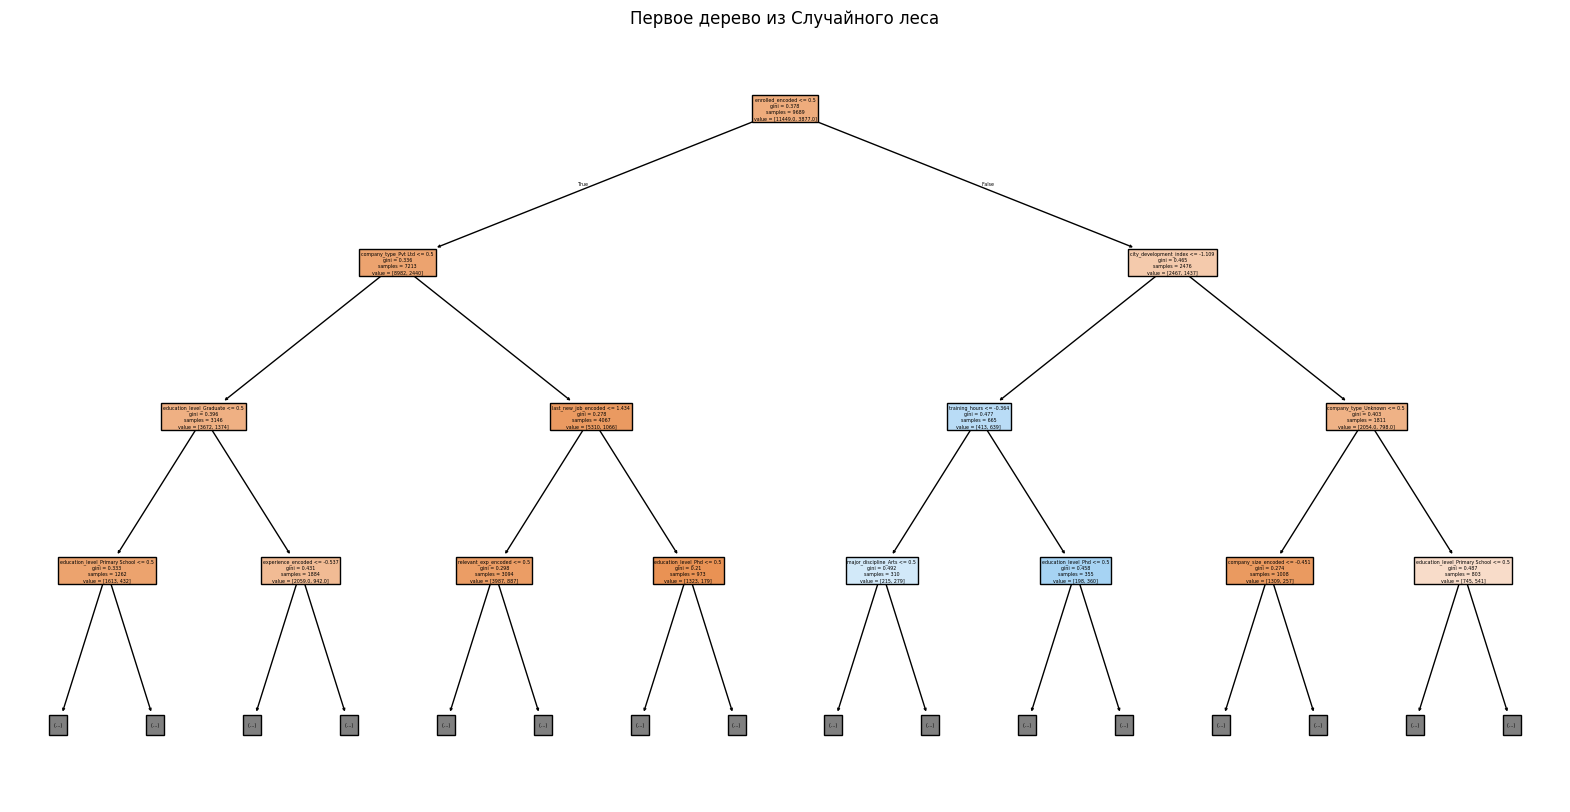

In [35]:
# Визуализирую одно дерево из леса
fig, ax = plt.subplots(figsize=(20, 10))
plot_tree(rf_model.estimators_[0],
          feature_names=X_train.columns,
          filled=True,
          max_depth=3,
          ax=ax)
plt.title("Первое дерево из Случайного леса")
plt.savefig('decision_tree.png', dpi=300, bbox_inches='tight')
plt.show()

In [27]:
# Какие признаки влияют на уход
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Топ-10 важных признаков для предсказания ухода:")
print(feature_importance.head(10))

# Сохраняю для дашборда
feature_importance.to_csv('feature_importance.csv', index=False)

Топ-10 важных признаков для предсказания ухода:
                     feature  importance
0     city_development_index    0.251578
1             training_hours    0.245648
4         experience_encoded    0.142369
7       company_size_encoded    0.088935
5       last_new_job_encoded    0.068678
3             gender_encoded    0.031772
6           enrolled_encoded    0.028187
14      company_type_Unknown    0.023052
2       relevant_exp_encoded    0.019725
15  education_level_Graduate    0.016705


In [29]:
test_df = pd.read_csv('aug_test.csv')
# Обработка test данных
X_test = create_ml_dataset(test_df, is_training=False, scaler=fitted_scaler)

# Предсказания
test_predictions = rf_model.predict(X_test)
test_probabilities = rf_model.predict_proba(X_test)[:, 1]

print(f"Test predictions: {test_predictions[:10]}...")
print(f"Test probabilities: {test_probabilities[:10]}")
print(f"Уйдут: {(test_predictions == 1).sum()} сотрудников")
print(f"Останутся: {(test_predictions == 0).sum()} сотрудников")

Test predictions: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]...
Test probabilities: [0.1  0.12 0.17 0.03 0.05 0.46 0.78 0.3  0.3  0.47]
Уйдут: 430 сотрудников
Останутся: 1699 сотрудников


In [30]:
# Сравнение с train распределением
print("Train data:")
print(f"Уйдут: {(y_train == 1).sum()} ({((y_train == 1).mean()*100):.1f}%)")
print(f"Останутся: {(y_train == 0).sum()} ({((y_train == 0).mean()*100):.1f}%)")

print("\nTest predictions:")
print(f"Уйдут: {(test_predictions == 1).sum()} ({((test_predictions == 1).mean()*100):.1f}%)")
print(f"Останутся: {(test_predictions == 0).sum()} ({((test_predictions == 0).mean()*100):.1f}%)")

# Модель успешно обучена и готова к использованию,
# распределение предсказаний реалистичное

Train data:
Уйдут: 4777 (24.9%)
Останутся: 14381 (75.1%)

Test predictions:
Уйдут: 430 (20.2%)
Останутся: 1699 (79.8%)


In [37]:
# Создаю CSV для дашборда
new_test = pd.read_csv('aug_test.csv')
dashboard_data = handle_missing_values(new_test)
dashboard_data['prediction'] = test_predictions
dashboard_data['risk_score'] = test_probabilities

# Сохраняю
dashboard_data.to_csv('dashboard_data.csv', index=False, encoding='utf-8')